# Peakfinder

## Introduction

This notebook takes input data from ASR-recordings in the form of an input folder containing the CSV files for each recording day and animal, giving output files regarding the average reaction of each animal to each experiment. <br>The code is annotated and a more extensive explanation is contained within `Protocol.pdf`. 

## Imports

If this is your first time running this, you may need to install various python packages using pip. <br>
Open the terminal, either the windows command console or the VSC terminal, and run the command `pip install MODULENAME` for every module listed in the cell below (for example, `pip install pandas` to install pandas). Some of them may already be installed. Repeat this for the imports in `Analyzer.ipynb`.

In [82]:
import pandas as pd       
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict, Counter
from IPython.display import clear_output
import re
import ast

## Configuration

In [83]:
input_dir = "2025" # - - - - - - - - - - - - - - - - - - - - - folder containing folders with .CSV files; change this to your own input directory

output_dir = "Results" # - - - - - - - - - - - - - - - - - - - folder containing final results

filename = "Output" # - - - - - - - - - - - - - - - - - - - -  name of the output files

verbose = True # - - - - - - - - - - - - - - - - - - - - - - - enables more output messages which can help identify problems; the notebook will only return errors if False

use_RMS = True # - - - - - - - - - - - - - - - - - - - - - - - use RMS instead of raw strength

separate_top_10 = False # - - - - - - - - - - - - - - - - - -  put results from the first 10 recordings of every animal on every day into a separate file

discard_peakless = True # - - - - - - - - - - - - - - - - - -  discard recordings without peaks from analysis

more_data = True # - - - - - - - - - - - - - - - - - - - - - - also includes peakTime and difference between peakTime and reactionTime in output

keep_repetitions = False # - - - - - - - - - - - - - - - - - - does not average across trial repetitions if True

replace = False # - - - - - - - - - - - - - - - - - - - - - -  replace last output instead of making a new one

output = True # - - - - - - - - - - - - - - - - - - - - - - -  output results; set to False for testing if you do not want any change in output files when running the notebook

detection_threshold = 24 # - - - - - - - - - - - - - - - - - - threshold multiplier for detecting peaks, ValueG has to exceed n times the background noise per animal

RT_threshold = 6 # - - - - - - - - - - - - - - - - - - - - - - threshold multiplier for measuring reaction time, ValueG has to exceed n times the background noise per animal

length = 500 # - - - - - - - - - - - - - - - - - - - - - - - - length of the time window in milliseconds (both before and after the startle)

example_number = 34 # - - - - - - - - - - - - - - - - - - - -  index of the trial used for the example plot

background_offset = 200 # - - - - - - - - - - - - - - - - - -  measure background noise up to this many ms before the startle time (increase if a prepulse is played this or further away from the startle)

signal_offset = 200 # - - - - - - - - - - - - - - - - - - - -  check for signal up to this many ms after the startle time

exclude = ["offset_PPI", "offset_ASR"] # - - - - - - - - - - - experiment types to be excluded from analysis; comment out to include all
#exclude = ["ASR_control", "gap_depth"]

In [84]:
# Input startle times for every experiment
startle_times = {

    "ASR_control":      10000,
    "gap_depth":        10100,
    "gap_duration_10":  10060,
    "gap_duration_20":  10070,
    "gap_duration_4":   10054,
    "gap_duration_50":  10100,
    "gap_duration_8":   10058,
    "offset_ASR":       10010,
    "offset_PPI_10":    10010,
    "offset_PPI_12":    10012,
    "offset_PPI_14":    10014,
    "offset_PPI_16":    10016,
    "offset_PPI_18":    10018,
    "offset_PPI_20":    10020,
    "offset_PPI_4":     10004,
    "offset_PPI_6":     10006,
    "offset_PPI_8":     10008,
    "offset_PPI_50":    10050,
    "tone_in_noise":    10100
    
}

In [85]:
# Input sex for every animal
sex = {
    "1":    "female",
    "2":    "male",
    "4":    "male",
    "6":    "female",
    "10":   "female",
    "15":   "male"
}

In [86]:
# CSV file settings (insert columns like how they'd appear in an excel file, as in starting with column 1)

data_start =           5   # row where recording data starts

animal_column =        2   # column "Animal. No."
experiment_column =    8   # column "Exp. No."
weight_column =        6   # column "Weight"
number_column =        18  # column "TrialNo"
name_column =          17  # column "Trial"
time_column =          19  # column "MS"
value_column =         20  # column "ValueG"

# adjust columns to be 0-indexed
experiment_column, weight_column, number_column, name_column, time_column, value_column = (x - 1 for x in (experiment_column, weight_column, number_column, name_column, time_column, value_column))

## Slicing

In [87]:
segments = {}
startles = {}
weights = {}

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.lower().endswith('.csv'):
            file_path = os.path.join(root, file)
            df = pd.read_csv(file_path, low_memory=False, skiprows=[0, 2])

            animal_number = df.iloc[data_start + 1, animal_column]
            date = file[:-4].split('_')[1]
            animal_str = f"Animal{animal_number}"

            df.iloc[:, value_column] = pd.to_numeric(df.iloc[:, value_column], errors='coerce')

            df.iloc[:, value_column] = abs(df.iloc[:, value_column])

            df['trial'] = df.iloc[:, name_column]
            df['trial_shift'] = df['trial'].shift(1)
            df['new_segment'] = df['trial'] != df['trial_shift']
            df['segment_id'] = df['new_segment'].cumsum()

            repetition = {}

            for segment_id, segment_df in df.groupby('segment_id'):
                trial_name = segment_df.iloc[0]['trial']
                repetition[trial_name] = repetition.get(trial_name, 0) + 1

                segment_startle = startle_times.get(trial_name)
                if segment_startle is None:
                    raise Exception(f"Missing startle time for {trial_name}. Please make sure it is included in the startle_times dictionary.")

                segment_name = f"{animal_str}_{date}_{trial_name}_Rep{repetition[trial_name]}"

                segment_length = len(segment_df)
                time_col = np.arange(0, segment_length * 2, 2)
                segment_data = pd.DataFrame({
                    0: time_col,
                    1: segment_df.iloc[:, value_column].values
                })

                segments[segment_name] = segment_data
                startles[segment_name] = segment_startle
                if verbose: print(f"Processed {segment_name}.")

counts = Counter([segment_df.iloc[0]['trial'] for _, segment_df in df.groupby('segment_id')])

clear_output(wait=False)

if verbose: 
    print(f"Processed {len(segments)} segments.") # 1710 expected
    print("Repetition count per experiment:")
    for name, count in sorted(counts.items()):
        print(f"{name}: {count}") # 5 each expected

Processed 1645 segments.
Repetition count per experiment:
ASR_control: 5
gap_depth: 5
gap_duration_10: 5
gap_duration_20: 5
gap_duration_4: 5
gap_duration_50: 5
gap_duration_8: 5
offset_ASR: 5
offset_PPI_10: 5
offset_PPI_12: 5
offset_PPI_14: 5
offset_PPI_16: 5
offset_PPI_18: 3
offset_PPI_20: 4
offset_PPI_4: 5
offset_PPI_50: 4
offset_PPI_6: 4
offset_PPI_8: 5
tone_in_noise: 5


In [88]:
# Get background noise per animal
animal_noise_intermediate = {}

experiment_keys = [t[0] for t in sorted(counts.items())]

for key in segments.keys():
    # Extract animal name
    animal = key.split('_')[0]

    # Find experiment prefix in key
    matching_prefix = None
    for exp_key in experiment_keys:
        if exp_key in key:
            matching_prefix = exp_key
            break

    if matching_prefix is None:
        print(f"No experiment prefix found for key: {key}")
        continue

    startle_time = startle_times.get(matching_prefix)
    if startle_time is None:
        print(f"No startle time found for experiment: {matching_prefix}")
        continue

    df = segments[key]

    # Convert time column to numeric
    df.iloc[:, 0] = pd.to_numeric(df.iloc[:, 0], errors='coerce')

    start_time = 0
    end_time = startle_time - background_offset  # measure up to 200ms before the startle
    if end_time <= start_time:
        print(f"Invalid time window for {key}: startle_time={startle_time}")
        continue

    mask = (df.iloc[:, 0] >= start_time) & (df.iloc[:, 0] < end_time)
    background_window = df.loc[mask].iloc[:, 1]

    if background_window.empty:
        print(f"No data in background window for {key}")
        continue

    noise_level = background_window.std()

    # Store noise levels per animal and experiment across repetitions
    animal_noise_intermediate.setdefault(animal, {}).setdefault(matching_prefix, []).append(noise_level)

# Median noise across repetitions per experiment per animal
animal_noise_median = {}
for animal, exp_dict in animal_noise_intermediate.items():
    animal_noise_median[animal] = {}
    for exp, noise_list in exp_dict.items():
        animal_noise_median[animal][exp] = float(np.median(noise_list))

# Median noise across experiments per animal
animal_noise = {}
for animal, exp_dict in animal_noise_median.items():
    all_exp_values = list(exp_dict.values())
    if all_exp_values:
        animal_noise[animal] = round(float(np.median(all_exp_values)), 2)
    else:
        animal_noise[animal] = None

if verbose:
    print(f"Collected background noise for {len(animal_noise)} animals:")
    print(animal_noise)


Collected background noise for 6 animals:
{'Animal10': 0.42, 'Animal15': 1.04, 'Animal1': 0.51, 'Animal2': 0.45, 'Animal4': 0.58, 'Animal6': 0.42}


In [89]:
# Cut the segments
adjusted_segments = {}
for entry in segments:
    df = segments[entry]
    reference_time = startles[entry]  

    # Filter the data to get rows within the 1000 ms before and after the reference time
    start_time = reference_time - length
    end_time = reference_time + length

    # Filter the dataframe to include only the data within the time range
    filtered_df = df[(df.iloc[:, 0] >= start_time) & (df.iloc[:, 0] <= end_time)].copy()

    # Adjust the time column to set the reference time to 0
    filtered_df.iloc[:, 0] = filtered_df.iloc[:, 0] - reference_time

    filtered_df.reset_index(drop=True, inplace=True) 

    adjusted_segments[entry] = filtered_df

    #if verbose: print(f"Adjusted {entry}.")

In [90]:
# Split off top 10 recordings
if separate_top_10:
    animal_date_keys = defaultdict(list)

    for key in adjusted_segments.keys():
        parts = key.split('_')
        animal = parts[0]
        date = parts[1]
        animal_date_keys[(animal, date)].append(key)

    # Take first 10 keys per animal per date
    top_10 = {}
    for (animal, date), keys in animal_date_keys.items():
        first_10_keys = keys[:10]
        for k in first_10_keys:
            top_10[k] = adjusted_segments[k]

    # Remove top 10 entries per animal and day from adjusted_segments
    for key in top_10.keys():
        del adjusted_segments[key]

    if verbose: print(f"Moved {len(top_10)} segments to a separate file.") # 120 expected
else:
    top_10 = {}

In [91]:
before = len(adjusted_segments)
# Remove excluded experiments
for key in adjusted_segments.keys():
    adjusted_segments = {   # remove excluded keys
    key: value
    for key, value in adjusted_segments.items()
    if not any(word in key for word in exclude)
}
if verbose: print(f"Excluded {before-len(adjusted_segments)} segments from regular dataset.")

if separate_top_10: before_top_10 = len(top_10)
# Remove excluded experiments
for key in top_10.keys():
    top_10 = {   # remove excluded keys
    key: value
    for key, value in top_10.items()
    if not any(word in key for word in exclude)
}
if verbose and separate_top_10: print(f"Excluded {before_top_10-len(top_10)} segments from top 10 dataset.")

Excluded 952 segments from regular dataset.


## Signal Detection

In [92]:
animal_thresholds = {animal: animal_noise[animal] * RT_threshold for animal in animal_noise}
if verbose: print(animal_thresholds)
animal_thresholds_det = {animal: animal_noise[animal] * detection_threshold for animal in animal_noise}
if verbose: print(animal_thresholds_det)

{'Animal10': 2.52, 'Animal15': 6.24, 'Animal1': 3.06, 'Animal2': 2.7, 'Animal4': 3.4799999999999995, 'Animal6': 2.52}
{'Animal10': 10.08, 'Animal15': 24.96, 'Animal1': 12.24, 'Animal2': 10.8, 'Animal4': 13.919999999999998, 'Animal6': 10.08}


In [93]:
signal_results = {}
signal_results_top_10 = {}

for key, df in adjusted_segments.items():
    animal = key.split('_')[0]
    noise = animal_noise.get(animal)

    # Set post-startle window
    mask = (df.iloc[:, 0] >= 0) & (df.iloc[:, 0] <= signal_offset)
    window = df.loc[mask].iloc[:, 1]

    # Threshold detection
    detected = not window.empty and window.max() > detection_threshold * noise
    signal_results[key] = detected

if verbose: print(signal_results)


for key, df in top_10.items():
    animal = key.split('_')[0]
    noise = animal_noise.get(animal)

    # Extract post-startle window
    mask = (df.iloc[:, 0] >= 0) & (df.iloc[:, 0] <= signal_offset)
    window = df.loc[mask].iloc[:, 1]

    # Threshold detection
    detected = not window.empty and window.max() > detection_threshold * noise
    signal_results_top_10[key] = detected

if separate_top_10 and verbose: print(signal_results_top_10)

{'Animal10_April16_gap_duration_4_Rep1': np.True_, 'Animal10_April16_gap_depth_Rep1': np.True_, 'Animal10_April16_gap_duration_10_Rep1': np.True_, 'Animal10_April16_gap_depth_Rep2': np.True_, 'Animal10_April16_gap_duration_10_Rep2': np.True_, 'Animal10_April16_gap_duration_8_Rep1': np.True_, 'Animal10_April16_gap_depth_Rep3': np.True_, 'Animal10_April16_gap_duration_50_Rep1': np.True_, 'Animal10_April16_gap_duration_4_Rep2': np.True_, 'Animal10_April16_tone_in_noise_Rep1': np.True_, 'Animal10_April16_gap_duration_50_Rep2': np.True_, 'Animal10_April16_tone_in_noise_Rep2': np.True_, 'Animal10_April16_gap_duration_8_Rep2': np.True_, 'Animal10_April16_gap_duration_4_Rep3': np.True_, 'Animal10_April16_gap_duration_50_Rep3': np.True_, 'Animal10_April16_gap_duration_20_Rep1': np.True_, 'Animal10_April16_gap_duration_8_Rep3': np.True_, 'Animal10_April16_tone_in_noise_Rep3': np.True_, 'Animal10_April16_gap_duration_50_Rep4': np.True_, 'Animal10_April16_ASR_control_Rep1': np.True_, 'Animal10_Apr

In [94]:
animal_hits = {}
animal_misses = {}
animal_hits_top_10 = {}
animal_misses_top_10 = {}

for key, detected in signal_results.items():
    animal = key.split('_')[0]
    if detected:
        animal_hits[animal] = animal_hits.get(animal, 0) + 1
    else:
        animal_misses[animal] = animal_misses.get(animal, 0) + 1

animal_hit_rate = {}
for animal in animal_hits.keys() | animal_misses.keys():
    hits = animal_hits.get(animal, 0)
    misses = animal_misses.get(animal, 0)
    total = hits + misses
    animal_hit_rate[animal] = round(hits / total, 2) if total > 0 else None

for key, detected in signal_results_top_10.items():
    animal = key.split('_')[0]
    if detected:
        animal_hits_top_10[animal] = animal_hits_top_10.get(animal, 0) + 1
    else:
        animal_misses_top_10[animal] = animal_misses_top_10.get(animal, 0) + 1

animal_hit_rate_top_10 = {}
for animal in animal_hits_top_10.keys() | animal_misses_top_10.keys():
    hits = animal_hits_top_10.get(animal, 0)
    misses = animal_misses_top_10.get(animal, 0)
    total = hits + misses
    animal_hit_rate_top_10[animal] = round(hits / total, 2) if total > 0 else None


if verbose: print(animal_hit_rate) # seem too high?
if separate_top_10 and verbose: print(animal_hit_rate_top_10) # separate? do these values even mean anything given that it's just 10? can we try to compare them to see if there are less peaks proportionally in the first 10?

{'Animal2': 1.0, 'Animal10': 1.0, 'Animal6': 1.0, 'Animal15': 0.97, 'Animal1': 0.99, 'Animal4': 1.0}


In [95]:
# Check recordings without peaks
false_keys = [key for key, value in signal_results.items() if not value]
false_keys_top_10 = [key for key, value in signal_results_top_10.items() if not value]

print(false_keys) 
if separate_top_10: print(false_keys_top_10)


['Animal15_April16_tone_in_noise_Rep2', 'Animal15_April16_gap_duration_4_Rep5', 'Animal15_April16_gap_duration_20_Rep5', 'Animal1_April16_tone_in_noise_Rep4']


In [96]:
# Remove entries without peaks TRY LOWERING TO 35
if discard_peakless:
    data = {k: v for k, v in adjusted_segments.items() if signal_results.get(k, False)}
    data_top_10 = {k: v for k, v in top_10.items() if signal_results_top_10.get(k, False)}
    if verbose: print(f"Removed {len(adjusted_segments)-len(data)} entries without peaks from regular dataframe.")
    if separate_top_10 and verbose: print(f"Removed {len(top_10)-len(data_top_10)} entries without peaks from top 10 dataframe.")
else:
    data = adjusted_segments
    data_top_10 = top_10

Removed 4 entries without peaks from regular dataframe.


## Plotting

In [97]:
def plot_segment(name, segments):

    df = segments[name]
    startle_x = 0

    plot_noise = animal_noise.get(name.split("_")[0])

    plot_threshold_1 = plot_noise * detection_threshold 
    plot_threshold_2 = animal_thresholds[name.split("_")[0]]

    df = df.iloc[::1]  # only use every n-th value for plotting

    plot_title = name
    plt.figure(figsize=(8, 6))
    plt.plot(df[0], df[1], color="#000000", marker="o", markersize=0, linewidth=1.25)
    plt.axvline(x=startle_x, color="#FF0000", linewidth=2, linestyle='dotted', label="Startle")

    plt.axhline(y=plot_threshold_1, color="#CE1195", linewidth=2, linestyle='dotted', label=f"Detection Threshold (k={detection_threshold})")
    plt.axhline(y=plot_threshold_2, color="#11CE4A", linewidth=2, linestyle='dotted', label=f"Measurement Threshold (k={RT_threshold})")
    plt.axhline(y=plot_noise, color="#4400FF", linewidth=2, linestyle='dotted', label=f"Background Noise ({plot_noise})")
    
    plt.xlabel("Time (ms)", fontsize=12)
    plt.ylabel("ValueG", fontsize=12)
    plt.title(plot_title, fontsize=14)
    
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend()

    plt.show()

In [98]:
example_name =  list(data.keys())[example_number] # get example recording

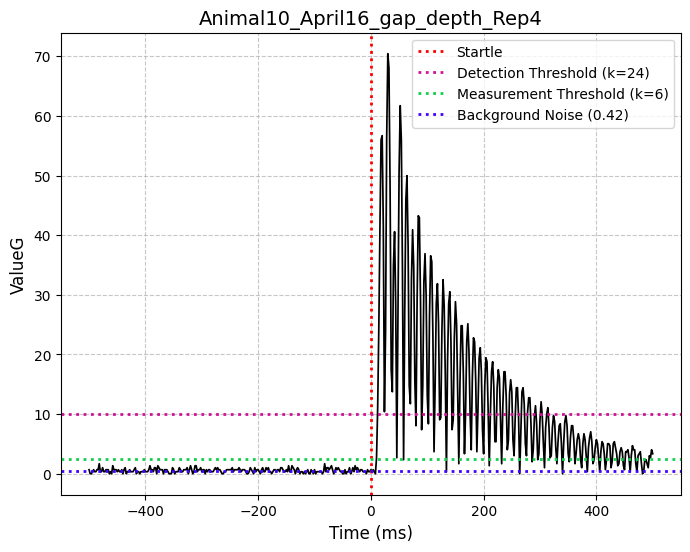

In [99]:
plot_segment(example_name, data) 

In [100]:

# 20 and 30: 
#plot_segment("Animal15_April16_tone_in_noise_Rep2", adjusted_segments) # do not want
#plot_segment("Animal1_April16_tone_in_noise_Rep4", adjusted_segments) # do not want
# 35:
# Animal15_April16_tone_in_noise_Rep2 -> do not want
# Animal1_April16_tone_in_noise_Rep4 -> do not want
# 40:
#plot_segment("Animal15_May20_tone_in_noise_Rep5", adjusted_segments) # want
#plot_segment("Animal1_May20_ASR_control_Rep5", adjusted_segments) # do not want
#plot_segment("Animal15_April16_ASR_control_Rep2", top_10) # want

#plot_segment('Animal15_April16_tone_in_noise_Rep2', adjusted_segments)
#plot_segment('Animal15_April16_gap_duration_8_Rep5', adjusted_segments)
#plot_segment('Animal15_April16_gap_duration_4_Rep5', adjusted_segments)
#plot_segment('Animal15_April16_gap_duration_20_Rep5', adjusted_segments)
#plot_segment('Animal1_April16_tone_in_noise_Rep4', adjusted_segments)


## Analysis

In [101]:
reaction = {}

for entry in data:
    times = data[entry][0]
    values = data[entry][1]
    
    indices_above_threshold = np.where((values > animal_thresholds[entry.split("_")[0]]) & (times > 0))[0]

    if len(indices_above_threshold) > 0:
        peak_start = times[indices_above_threshold[0]]  # first time a value passes the threshold
        start_value = values[indices_above_threshold[0]]  # first value that passes the threshold

        min_value = min(values[indices_above_threshold])  # minimum value among those above the threshold
        min_value_index = indices_above_threshold[np.argmin(values[indices_above_threshold])]
        min_time = times[min_value_index]

        max_value = max(values[indices_above_threshold])  # maximum value among those above the threshold
        max_value_index = indices_above_threshold[np.argmax(values[indices_above_threshold])]
        max_time = times[max_value_index]

        buildup = max_time - peak_start

        if use_RMS:
            rms_value = np.sqrt(np.mean(np.square(values[indices_above_threshold]))) # calculate RMS
        else:
            rms_value = max_value  

        reaction[entry] = {
            "reactionTime": int(peak_start),
            "peakTime": int(max_time),
            "difference": int(buildup),
            "strength (RMS)" if use_RMS else "strength (raw)": int(rms_value) 
            } if more_data else {"reactionTime": int(peak_start), "strength (RMS)" if use_RMS else "strength (raw)": int(rms_value)} # exclude peakTime and difference 
        if verbose: print(f"Processed {entry}.")
    else:
        if discard_peakless: 
            raise Exception(f"No peak found for {entry}. This likely indicates an error in code block 15, wherein all recordings without peaks should be discarded.")
        else:
            pass # you could add logic for handling peakless recordings here


clear_output(wait=False)
if verbose: print(f"Created {len(reaction)} entries for regular reactions.")

Created 689 entries for regular reactions.


In [102]:
reaction_top_10 = {}

for entry in data_top_10:
    times = data_top_10[entry][0]
    values = data_top_10[entry][1]
    
    indices_above_threshold = np.where((values > animal_thresholds[entry.split("_")[0]]) & (times > 0))[0]

    if len(indices_above_threshold) > 0:
        peak_start = times[indices_above_threshold[0]]  # first time a value passes the threshold
        start_value = values[indices_above_threshold[0]]  # first value that passes the threshold

        min_value = min(values[indices_above_threshold])  # minimum value among those above the threshold
        min_value_index = indices_above_threshold[np.argmin(values[indices_above_threshold])]
        min_time = times[min_value_index]

        max_value = max(values[indices_above_threshold])  # maximum value among those above the threshold
        max_value_index = indices_above_threshold[np.argmax(values[indices_above_threshold])]
        max_time = times[max_value_index]

        buildup = max_time - peak_start

        if use_RMS:
            rms_value = np.sqrt(np.mean(np.square(values[indices_above_threshold]))) # calculate RMS
        else:
            rms_value = max_value  

        reaction_top_10[entry] = {
            "reactionTime": int(peak_start),
            "peakTime": int(max_time),
            "difference": int(buildup),
            "strength (RMS)" if use_RMS else "strength (raw)": int(rms_value) 
            } if more_data else {"reactionTime": int(peak_start), "strength (RMS)" if use_RMS else "strength (raw)": int(rms_value)} # exclude peakTime and difference 
        if verbose: print(f"Processed {entry}.")
    else:
        if separate_top_10 and discard_peakless: 
            raise Exception(f"No peak found for {entry}. This indicates an error in code block 15, wherein all recordings without peaks should be discarded.")
        else:
            pass # you could add logic for handling peakless recordings here


clear_output(wait=False)
if verbose and separate_top_10: print(f"Created {len(reaction_top_10)} entries for first 10 reactions.")

## Saving

In [103]:
pattern = re.compile(r'^(?P<animal>\w+)_(?P<date>\w+?)_(?P<experiment>.+?)_Rep\d+$')

# Group and average
intermediate = defaultdict(lambda: {
    "animal": [], "sex": [], "date": [], "reactionTime": [], "peakTime": [], "difference": [], "strength": []
}) if more_data else defaultdict(lambda: {
    "animal": [], "sex": [], "date": [], "reactionTime": [], "strength": []
})

for entry, values in reaction.items():
    parts = entry.split("_")
    animal = parts[0]
    date = parts[1]

    experiment = [p for p in parts[2:] if not p.lower().startswith('rep')] # remove repetition number
    
    key = f"{animal}_{date}_{experiment}"  # unique key

    intermediate[key]["animal"].append(animal)
    intermediate[key]["date"].append(date)
    intermediate[key]["reactionTime"].append(values["reactionTime"])

    if more_data: intermediate[key]["peakTime"].append(values["peakTime"]) 
    if more_data: intermediate[key]["difference"].append(values["difference"])
    
    strength_value = values.get("strength (RMS)" if use_RMS else "strength (raw)", None)
    intermediate[key]["strength"].append(strength_value)


# Group and average top 10
intermediate_top_10 = defaultdict(lambda: {
    "animal": [], "sex": [], "date": [], "reactionTime": [], "peakTime": [], "difference": [], "strength": []
}) if more_data else defaultdict(lambda: {
    "animal": [], "sex": [], "date": [], "reactionTime": [], "strength": []
})

for entry, values in reaction_top_10.items():
    parts = entry.split("_")
    animal = parts[0]
    date = parts[1]

    experiment = [p for p in parts[2:] if not p.lower().startswith('rep')] # remove repetition number
    
    key = f"{animal}_{date}_{experiment}"  # unique key

    intermediate_top_10[key]["animal"].append(animal)
    intermediate_top_10[key]["date"].append(date)
    intermediate_top_10[key]["reactionTime"].append(values["reactionTime"])
    
    if more_data: intermediate_top_10[key]["peakTime"].append(values["peakTime"])
    if more_data: intermediate_top_10[key]["difference"].append(values["difference"])
    
    strength_value = values.get("strength (RMS)" if use_RMS else "strength (raw)", None)
    intermediate_top_10[key]["strength"].append(strength_value)

In [104]:
averaged = []
for key, metrics in intermediate.items():
    parts = key.split("_")
    animal = parts[0]
    date = parts[1]
    experiment = '_'.join(ast.literal_eval('_'.join(parts[2:]))) # don't ask, it works

    averaged.append({
        "animal": animal,
        "sex": sex[animal.replace("Animal", "")],
        "date": date,
        "experiment": experiment,
        "reactionTime": round(sum(metrics["reactionTime"]) / len(metrics["reactionTime"]), 2),
        "peakTime": round(sum(metrics["peakTime"]) / len(metrics["peakTime"]), 2),
        "difference": round(sum(metrics["difference"]) / len(metrics["difference"]), 2),
        "strength": round(sum(metrics["strength"]) / len(metrics["strength"]), 2)
    }) if more_data else averaged.append({
        "animal": animal,
        "sex": sex[animal.replace("Animal", "")],
        "date": date,
        "experiment": experiment,
        "reactionTime": round(sum(metrics["reactionTime"]) / len(metrics["reactionTime"]), 2),
        "strength": round(sum(metrics["strength"]) / len(metrics["strength"]), 2)
    })

# Repeat for top 10
averaged_top_10 = []
for key, metrics in intermediate_top_10.items():
    parts = key.split("_")
    animal = parts[0]
    date = parts[1]
    experiment = '_'.join(ast.literal_eval('_'.join(parts[2:])))

    averaged_top_10.append({
        "animal": animal,
        "sex": sex[animal.replace("Animal", "")],
        "date": date,
        "experiment": experiment,
        "reactionTime": round(sum(metrics["reactionTime"]) / len(metrics["reactionTime"]), 2),
        "peakTime": round(sum(metrics["peakTime"]) / len(metrics["peakTime"]), 2),
        "difference": round(sum(metrics["difference"]) / len(metrics["difference"]), 2),
        "strength": round(sum(metrics["strength"]) / len(metrics["strength"]), 2)
    }) if more_data else averaged_top_10.append({
        "animal": animal,
        "sex": sex[animal.replace("Animal", "")],
        "date": date,
        "experiment": experiment,
        "reactionTime": round(sum(metrics["reactionTime"]) / len(metrics["reactionTime"]), 2),
        "strength": round(sum(metrics["strength"]) / len(metrics["strength"]), 2)
    })

In [105]:
def get_number(s):
    match = re.search(r'(\d+)$', s)  
    return int(match.group(1)) if match else None

def get_experiment_type(s):
    return re.sub(r'[_\s-]?\d+$', '', s)

def get_animal_number(s):
    match = re.search(r'(\d+)', s)
    return int(match.group(1)) if match else None

In [106]:
reps = []
for key, metrics in intermediate.items():
    parts = key.split("_")
    animal = parts[0]
    date = parts[1]
    experiment = '_'.join(ast.literal_eval('_'.join(parts[2:]))) # don't ask, it works

    reps.append({
        "animal": animal,
        "sex": sex[animal.replace("Animal", "")],
        "date": date,
        "experiment": experiment,
        "reactionTime": metrics["reactionTime"],
        "peakTime": metrics["peakTime"],
        "difference": metrics["difference"],
        "strength": metrics["strength"]
    }) if more_data else reps.append({
        "animal": animal,
        "sex": sex[animal.replace("Animal", "")],
        "date": date,
        "experiment": experiment,
        "reactionTime": metrics["reactionTime"],
        "strength": metrics["strength"]
    })

reps_top_10 = []
for key, metrics in intermediate_top_10.items():
    parts = key.split("_")
    animal = parts[0]
    date = parts[1]
    experiment = '_'.join(ast.literal_eval('_'.join(parts[2:]))) # don't ask, it works

    reps_top_10.append({
        "animal": animal,
        "sex": sex[animal.replace("Animal", "")],
        "date": date,
        "experiment": experiment,
        "reactionTime": metrics["reactionTime"],
        "peakTime": metrics["peakTime"],
        "difference": metrics["difference"],
        "strength": metrics["strength"]
    }) if more_data else reps_top_10.append({
        "animal": animal,
        "sex": sex[animal.replace("Animal", "")],
        "date": date,
        "experiment": experiment,
        "reactionTime": metrics["reactionTime"],
        "strength": metrics["strength"]
    })

In [107]:
if output:
    os.makedirs(output_dir, exist_ok=True)

    counter = 1
    while os.path.exists(os.path.join(output_dir, str(counter))):
        counter += 1

    if replace: counter -= 1

    subfolder_path = os.path.join(output_dir, str(counter))

    if replace and not separate_top_10: os.remove(os.path.join(subfolder_path, f"{filename}_Top_10.xlsx"))

    os.makedirs(subfolder_path, exist_ok=True)

    dfs = [pd.DataFrame(averaged), pd.DataFrame(averaged_top_10)] if separate_top_10 and not keep_repetitions \
    else [pd.DataFrame(averaged)] if not separate_top_10 and not keep_repetitions \
    else [pd.DataFrame(reps)] if not separate_top_10 and keep_repetitions \
    else [pd.DataFrame(reps), pd.DataFrame(reps_top_10)] # I love coding

    for i, df in enumerate(dfs):
        # Sorting
        df['has_number'] = df['experiment'].str.contains(r'\d+$')
        df['experiment_number'] = df['experiment'].apply(get_number)
        df['experiment_type'] = df['experiment'].apply(get_experiment_type)
        df['animal_number'] = df['animal'].apply(get_animal_number)

        df = df.sort_values(['date', 'animal_number', 'has_number', 'experiment_type', 'experiment_number'])

        df = df.drop(columns=['has_number', 'experiment_type', 'experiment_number', 'animal_number'])

        df = df.reset_index(drop=True)

        # Naming and saving
        file_suffix = "_Top_10" if i == 1 else ""
        output_path = os.path.join(subfolder_path, f"{filename}{file_suffix}.xlsx")

        df.to_excel(output_path, index=False)

    if verbose: print(f"Saved results to: {subfolder_path}")

Saved results to: Results\1
